<a href="https://colab.research.google.com/github/iProlly/Comchem/blob/main/Oil_ML_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from google.colab import drive
from random import randrange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import io

In [2]:
raw = pd.read_csv('/content/IR_Orgchem_ATR.csv')

testing_number = 400
testing_data = []
testing_labels = []

labels = raw.iloc[:, 0].values
data = raw.iloc[:, 1:].values

for j in range(testing_number):
  random_index = randrange(len(data))
  testing_labels.append(labels[random_index])
  testing_data.append(data[random_index])
  data = np.delete(data, random_index, 0)
  labels = np.delete(labels, random_index, 0)

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)
X_train = X_train[..., np.newaxis]  # Add channel dimension for CNN
X_test = X_test[..., np.newaxis]
testing_data = testing_data[..., np.newaxis]

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(data.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.2699 - loss: 7161.0645 - val_accuracy: 0.2271 - val_loss: 108.3147
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.3021 - loss: 30.4118 - val_accuracy: 0.4729 - val_loss: 1.4170
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.5412 - loss: 1.2519 - val_accuracy: 0.5521 - val_loss: 0.9859
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6822 - loss: 0.7261 - val_accuracy: 0.5688 - val_loss: 0.9646
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7766 - loss: 0.5511 - val_accuracy: 0.5854 - val_loss: 0.9985
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.8521 - loss: 0.4079 - val_accuracy: 0.6021 - val_loss: 1.0323
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9035 - loss: 0.3177 - val_accuracy: 0.5979 - val_loss: 1.2253
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9496 - loss: 0.2191 - val_accu

In [6]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6312 - loss: 1.3390
Test accuracy: 61.46%


In [7]:
prediction = model.predict(testing_data)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction, axis=1)

# Decode the prediction to get the class label
predicted_class = label_encoder.inverse_transform(predicted_class_index)

point = 0
for i in range(len(predicted_class)):
  if predicted_class[i] == testing_labels[i]:
    point+=1
print("Percentage accuracy:", point/len(predicted_class)*100)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Percentage accuracy: 61.5


Confusion Matrix in Table Format:
       'O01'  'O02'  'O03'  'O04'
'O01'     91     20      0      0
'O02'     25     58     12     10
'O03'      0      3     57     25
'O04'      0      4     55     40


<Figure size 800x600 with 0 Axes>

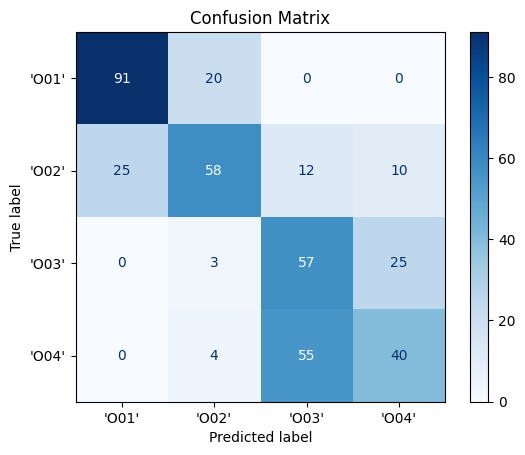

In [8]:
conf_matrix = confusion_matrix(testing_labels, predicted_class, labels=np.unique(labels))

# Optional: Display the confusion matrix as a formatted table
# Convert integer labels back to original string labels
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=label_encoder.classes_,  # Rows (True Labels)
    columns=label_encoder.classes_  # Columns (Predicted Labels)
)

# Display the confusion matrix
print("Confusion Matrix in Table Format:")
print(conf_matrix_df)

# Step 5: Visualize the Confusion Matrix (Optional)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()